# Visualize heatmap on Allen Brain reference map

## Description

**WHAT?** This notebook overlays certain values and plots heatmaps on the Allen Brain Reference map. 

**ASSUMPTION** (of the notebook): the structures/areas you are choosing **DO NOT** overlap. If they do, the generated plots cannot be interpreted.

**WHY?** This may aid in visualization gene expressions (or whatever values you can think of) per area.

**BUT** you should be careful about normalization and interpretation of such values! 

*Reference*: this notebook is roughly based on AllenSDK example for using the reference space: <https://allensdk.readthedocs.io/en/latest/_static/examples/nb/reference_space.html>


## How to run on JupyterHub

To run this notebook on JupyterHub:

1. Click on the launcher (the `+` icon), then click on `Terminal`
2. Type the following

    ```bash
    conda init
    source ~/.bashrc
    conda activate /home/jovyan/shared/envs/allensdk
    python -m ipykernel install --user --name allensdk
    ```

3. Confirm that you see the following:

    ```text
    Installed kernelspec allensdk in /home/jovyan/.local/share/jupyter/kernels/allensdk
    ```

4. Either click on the long JupyterHub launch link again to get this notebook. Or you can just download this notebook from Gitlab, then upload it to the `notebooks` folder (or anywhere you want) 

5. If/when asked to select a kernel, select `allensdk`. You can check by looking to the top right corner (near the bug icon): instead of `Python 3`, it should say `allensdk`. If it doesn't, you can click on that `Python 3` button to change kernel.

6. Then modify/add the parts about the `structs_and_vals` and `portions`.

## How to run locally

If you know what you're doing locally, you can just do `pip install allensdk` in your "local" virtual environments.

In [1]:
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from matplotlib import pyplot as plt

In [2]:
# change this with the acronyms for structures and values for them
#    these structures are the large structures
#         but you can change them if you know the acronyms, which you can search on Allen Brain
#    the values are random, they don't mean anything
#    the point is to have a heatmap with colors indicating these values

structs_and_vals = {
    'Isocortex': 2.2,
    'OLF': 3.1,
    'HPF': 5, 
    'CTXsp': 9,
    'STR': 1.4,
    'PAL': 2,
    'TH': 5.7,
    'HY': 0.01, 
    'MB': 0.3,
    'P': 0.2,
    'MY': 2.5, 
    'CB': 0.1,
}
structures = list(structs_and_vals.keys())


In [3]:
output_dir = '../data/allen-ref' # change this to where you want the data to be downloaded into
os.makedirs(output_dir)

In [4]:
reference_space_key = os.path.join('annotation', 'ccf_2017')
resolution = 25
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=Path(output_dir) / 'manifest.json')

# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 

In [5]:
annotation, meta = rspc.get_annotation_volume()
# The file should appear in the reference space key directory
os.listdir(Path(output_dir) / reference_space_key)

2023-10-19 21:34:25,278 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_25.nrrd


['annotation_25.nrrd']

In [6]:
rsp = rspc.get_reference_space()

In [7]:
tree.get_structures_by_acronym(['VS'])

[{'acronym': 'VS',
  'graph_id': 1,
  'graph_order': 1292,
  'id': 73,
  'name': 'ventricular systems',
  'structure_id_path': [997, 73],
  'structure_set_ids': [691663206],
  'rgb_triplet': [170, 170, 170]}]

In [8]:
tree.get_structures_by_acronym(structures)

[{'acronym': 'Isocortex',
  'graph_id': 1,
  'graph_order': 5,
  'id': 315,
  'name': 'Isocortex',
  'structure_id_path': [997, 8, 567, 688, 695, 315],
  'structure_set_ids': [2,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [112, 255, 113]},
 {'acronym': 'OLF',
  'graph_id': 1,
  'graph_order': 379,
  'id': 698,
  'name': 'Olfactory areas',
  'structure_id_path': [997, 8, 567, 688, 695, 698],
  'structure_set_ids': [2,
   3,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [154, 210, 189]},
 {'acronym': 'HPF',
  'graph_id': 1,
  'graph_order': 454,
  'id': 1089,
  'name': 'Hippocampal formation',
  'structure_id_path': [997, 8, 567, 688, 695, 1089],
  'structure_set_ids': [2,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [126, 208, 75]},
 {'acronym': 'CTXsp',
 

In [9]:
# binary tensory mask for each structure
# will take about 1 minute for the chosen structures in this notebook
masks = {
    x['acronym']: rsp.make_structure_mask([x['id']])
    for x in tqdm(tree.get_structures_by_acronym(structures))
}

100%|██████████| 12/12 [00:43<00:00,  3.59s/it]


In [10]:
# shape is slice
masks['OLF'].shape

(528, 320, 456)

In [11]:
# overall tensor mask
overall_mask = 0
for x in tqdm(structures):
    overall_mask += masks[x]
overall_mask = overall_mask > 0

100%|██████████| 12/12 [00:00<00:00, 28.50it/s]


In [12]:
# calculate expression
# assumption: NO OVERLAP between regions
expression = 0
for x in tqdm(structures):
    expression += masks[x] * structs_and_vals[x]

100%|██████████| 12/12 [00:03<00:00,  3.66it/s]


In [13]:
expression[~overall_mask] = np.nan

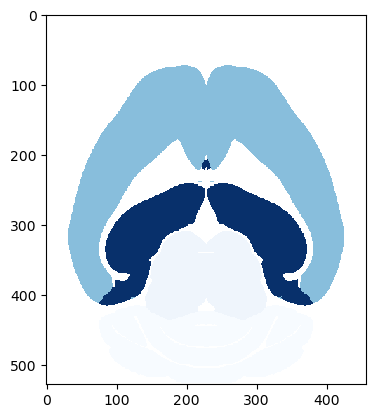

In [14]:
# example slice
plt.imshow(
    expression[:,100,:],
    interpolation='none',
    cmap='Blues'
)

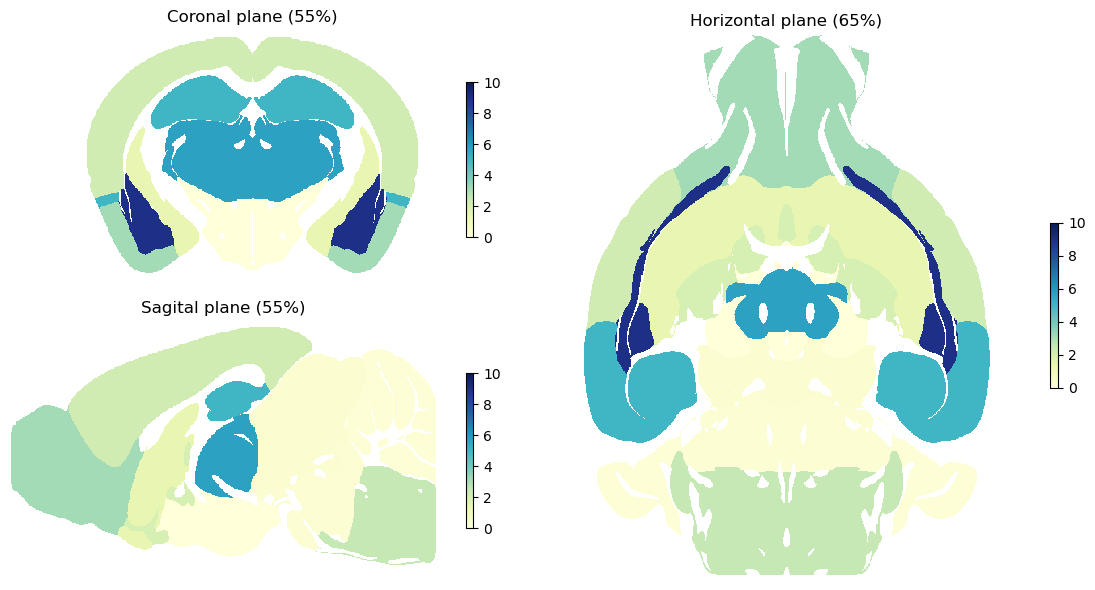

In [16]:
# plot at a certain portion of each axis
axis_names = ['Coronal', 'Horizontal', 'Sagital'] # name of each axis
portions = [0.55, 0.65, 0.55] # use this to control portion for each axis


fig = plt.figure(figsize=(12,6))

subplot_axes = [
    plt.subplot2grid((2, 2), (0, 0)),
    plt.subplot2grid((2, 2), (0, 1), rowspan=2),
    plt.subplot2grid((2, 2), (1, 0)),
]

tensor_dim = expression.shape
num_dim = len(tensor_dim)
for axis in range(num_dim):
    mid_axis = int(tensor_dim[axis] * portions[axis])
    idx_tup = [slice(None)] * num_dim
    idx_tup[axis] = mid_axis
    mat = expression[tuple(idx_tup)]
    if axis == 2: mat = mat.T    
    
    plt.sca(subplot_axes[axis])
    plt.imshow(
        mat,
        interpolation='none',
        cmap='YlGnBu', # change color map to what you want
        vmin = 0, # use this to control color lowerbound  
        vmax = 10, # use this to control color upperbound
    )
    
    plt.colorbar(shrink=0.3 if axis==1 else 0.6, ax=plt.gca())
    plt.title(f'{axis_names[axis]} plane ({portions[axis]*100:.0f}%)')
    plt.axis('off')

plt.tight_layout()

# plt.savefig('figures/myfigure.pdf') 